## Comparing the P values of different organims

Take the outputs of the script "P_calculation_on_trajectories", which contains the P values of the ingoing trajectories and plot the dsitribution as a violin plot


In [2]:
import pickle 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import progressbar
from os import walk
from glob import glob
import seaborn as sns 
from tkinter.filedialog import askdirectory, askopenfilename
from statistics import median
from scipy.stats import kruskal    
import scikit_posthocs as sp
from statannot import add_stat_annotation
import os
import random 

sns.set()
sns.set_style("ticks")
sns.set_context("poster")

px_um_conversion_factor = 2.703

In [23]:
# data where the straightness index data are stored
path = askdirectory()

# karlo
names_list = ['K_D200',
 'K_D20']
organism_name= 'Karlodinium'

# Oxy
names_list = ['O_D200',
 'O_D200',
 'O_D200',
 'O_D2O',
 'O_D2O',
 'O_D2O']
organism_name= 'Oxyrris'


# gyro
names_list = ['G_D200_R1_filtered',
 'G_D200_R2_filtered',
 'G_D200_R3_filtered',
 'G_D20_R1_filtered',
 'G_D20_R2_filtered',
 'G_D20_R3_filtered',
 'G_D20_R4_filtered']
organism_name= 'Gyrodinium'


### Robustness test control

In [5]:
# Colors with transparency (alpha)
neutral_color ="paleturquoise"
ingoing_color = "#8896AB"
outgoing_color = "#D81E5B"

# path to save the figure
save_path = askdirectory()

In [15]:
path

"C:/Users/UX325/Desktop/Queralt's FINAL FOLDER/Straightness_index_values_data"

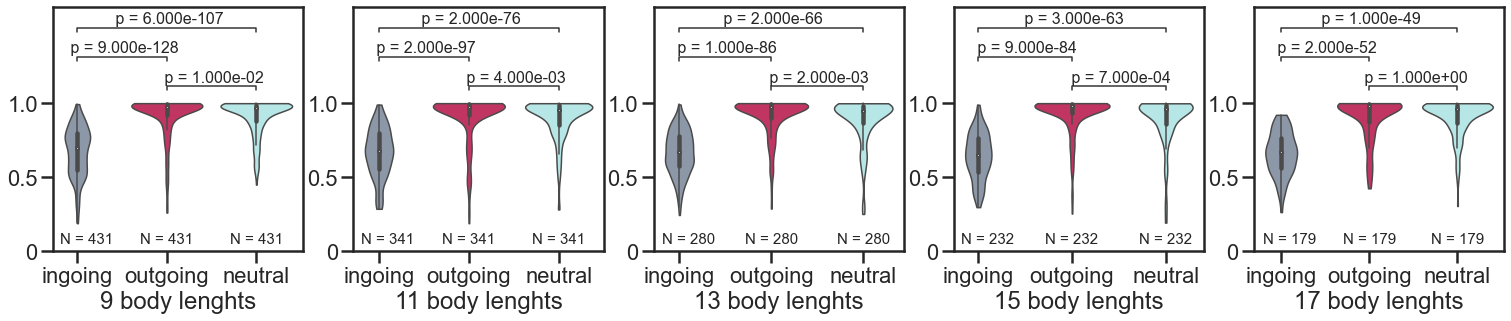

In [25]:
P_all = [] # control area 
P_all_in = [] # ingoing
P_all_out = []

# ranges: 20-27, 20-29, 20-31, etc..
n_array_control = np.array([27, 29, 31, 33, 35])
n_array_in_out = np.arange(10,20,2)

fig, axes = plt.subplots(1, len(n_array_in_out), figsize = (26,4.5))

for n, ax in enumerate(axes):
    
    # EXTRACT AND REAORGANIZE THE DATA
    
    n_control = n_array_control[n]
    n_in_out  = n_array_in_out[n]
    
    # get the files (check if they exists)
    files = [
        path + '/P_values_control_' + name + '_20_%i' % n_control 
        for name in names_list
        if os.path.exists(path + '/P_values_control_' + name + '_20_%i' % n_control)
        #else (print('P_values_control_' + name + '_20_%i does not exist' % n_control))
        ]

    files_in = [
        path + '/P_values_in_' + name + '_3_%i.txt' % n_in_out
        for name in names_list
        if os.path.exists(path + '/P_values_in_' + name + '_3_%i.txt' % n_in_out)
        #else (print('P_values_in_' + name + '_3_%i.txt does not exist' % n_in_out))
        ]

    files_out = [
        path + '/P_values_out_' + name + '_3_%i.txt' % n_in_out
        for name in names_list
        if os.path.exists(path + '/P_values_out_' + name + '_3_%i.txt' % n_in_out)
        #else (print('P_values_out_' + name + '_3_%i.txt does not exist' % n_in_out))
        ]

    P_n = []
    
    #control
    for file in files: 
        P_list = np.loadtxt(file)
        if len(P_list): # if not emptym this is True
            P_n.extend(P_list)
    
    P_all.append(P_n)    
    
    #in 
    P_n = []
    for file in files_in: 
        P_list = np.loadtxt(file)
        if len(P_list): # if not emptym this is True
            P_n.extend(P_list)
            
    P_all_in.append(P_n)    
    
    # out
    P_n = []
    for file in files_out: 
        P_list = np.loadtxt(file)
        if P_list.size >1: # if not emptym this is True
            P_n.extend(P_list)
    P_all_out.append(P_n)  
    
for n, ax in enumerate(axes): 
   
    arr1 = P_all_in[n]
    arr2 = P_all_out[n]
    arr3 = P_all[n]
    
    # reduce the datasets to the same number of points
    min_len = min( [len(arr1), len(arr2), len(arr3)])
    #print('number of points = %i' %int(min_len))

    # take a subsection of the data to see if the test depends on the number of points: IT DOES!!!!!!
    arr1 = [arr1[index] for index in [random.randint(0,len(arr1)-1) for _ in range(min_len)]]
    arr2 = [arr2[index] for index in [random.randint(0,len(arr2)-1) for _ in range(min_len)]]
    arr3 = [arr3[index] for index in [random.randint(0,len(arr3)-1) for _ in range(min_len)]]
    
    # get the new median values
    median_arr1 = "{:.2f}".format(np.median(arr1))
    median_arr2 = "{:.2f}".format(np.median(arr2))
    median_arr3 = "{:.2f}".format(np.median(arr3))
    
    # Combine data into a DataFrame
    data = {'Group': ['arr1'] * len(arr1) + ['arr2'] * len(arr2) + ['arr3']* len(arr3),
            'Value': np.concatenate([arr1, arr2, arr3])}
    df = pd.DataFrame(data)
    # remove spourious values (for oxyrris)
    df = df[df['Value'] <= 1]

    sns.violinplot(ax=ax, x='Group', y='Value', data=df, inner="box", 
                        cut = 0,
                        palette = {'arr1':ingoing_color , 'arr2': outgoing_color, 'arr3': neutral_color},
                        linewidth=1.5)
    
    posthoc_results = sp.posthoc_conover([arr1, arr2, arr3], p_adjust='bonferroni')
    
    ax.set_xticklabels(['ingoing','outgoing','neutral'])
    ax.set_xlabel('%i body lenghts' %(int(9+n*2)))
    ax.set_ylabel('')
    ax.set_ylim([0, 1.45])
    ax.set_yticks(ticks = [0, 0.5, 1.0], labels= ['0','0.5', '1.0'])
    # add number of points
    ax.text( 0.1, 0.05, 'N = %i'%min_len, horizontalalignment='center', fontsize = 15)
    ax.text( 1, 0.05, 'N = %i'%min_len, horizontalalignment='center', fontsize = 15)
    ax.text( 2, 0.05, 'N = %i'%min_len, horizontalalignment='center', fontsize = 15)
    
    # DO THE STATISTICS TEST
    # Perform Kruskal-Wallis test
    kruskal_result = kruskal(arr1, arr2, arr3)

    # Display the result
    #print("Kruskal-Wallis Test Statistic:", kruskal_result.statistic)
    #print("P-value:", kruskal_result.pvalue)
    
    # Perform Dunn's test for multiple comparisons
    # 'bonferroni' is used for adjusting p-values, you can choose another method if needed
    posthoc_results = sp.posthoc_conover([arr1, arr2, arr3], p_adjust='bonferroni')
    
    # in scientific notation with only one digit
    p_arr1_arr2 = float("{:.0e}".format(posthoc_results.iloc[0,1]))
    p_arr1_arr3 = float("{:.0e}".format(posthoc_results.iloc[0,2]))
    p_arr2_arr3 =  float("{:.0e}".format(posthoc_results.iloc[1,2]))
    
        # Add p-values
    box_pairs = [ ('arr1', 'arr3'),('arr3', 'arr2'), ('arr1', 'arr2')]

    test_results = add_stat_annotation(ax, data=df, x='Group', y='Value',
                                       box_pairs=box_pairs,
                                       perform_stat_test = False,
                                       pvalues= [p_arr1_arr3, p_arr2_arr3, p_arr1_arr2],
                                       text_format= 'full',
                                       loc='inside',
                                       fontsize = 16,
                                       verbose=0.1)
    
    # save the figure 
    #plt.savefig(save_path+'/final_plots/'+organism_name + '_supplementary_material.svg', bbox_inches = 'tight')
    
    # SAVE THE RESULTS of the tests IN A TXT FILE 
    file_name = save_path + '/tests_results_Kruskal+Dunns.txt'
    # Read existing content from the file
    try:
        with open(file_name, 'r') as file:
            existing_content = file.read()
    except FileNotFoundError:
        existing_content = ''

    # Open the file in append mode ('a')
    with open(file_name, 'w') as file:

        # Append or write new content
        file.write(existing_content)  # Write existing content first

        # Add a new line if the file is not empty
        if existing_content:
            file.write('\n')
            
        # Write a string with the data to the file
        data_string = organism_name + ' '  + '%i body lenghts' %(int(9+n*2))  + ' '
        data_string = data_string + str(int(kruskal_result.statistic)) + ' ' + "{:.0e}".format(kruskal_result.pvalue) + ' ' 
        data_string = data_string +  str(p_arr1_arr2) + ' ' + str(p_arr1_arr3)   + ' '  + str(p_arr2_arr3) 
        data_string =  data_string + ' '  +  median_arr1 + ' '  + median_arr2 + ' ' + median_arr3
        # 
        
        file.write(data_string)